In [115]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

Tensorflow version: 2.0.0
GPU: /device:GPU:0


In [116]:
!git clone https://github.com/michalovsky/books_data.git

fatal: destination path 'books_data' already exists and is not an empty directory.


In [127]:
import glob

def readData(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

text = readData(directory1)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 571642 characters


In [118]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove="", chars_to_translate="", replacement_chars=""):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = "".join( list( map(DataProcessor.__split_punctuation_from_sentence , text)))
		text = " ".join(text.split())
		return text
	
	@staticmethod
	def __split_punctuation_from_sentence(char):
		if (char == '.' or char == ','):
		  return (" " + char + " ")
		else:
			return (char)

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

unique_characters = sorted(list(set(text)))
print ('{} unique characters:'.format(len(unique_characters)))
print(unique_characters)

words = text.split()
print('Total words:', len(words))

vocab = sorted(set(words))
vocab_size = len(vocab)
print('Unique words:', vocab_size)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 117176
Unique words: 5611


In [119]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

word_to_indices = dict((w, i) for i, w in enumerate(vocab))
indices_to_word = dict((i, w) for i, w in enumerate(vocab))

class Dataset:
	def __init__(self):
		self.sequences = list()
		self.X_train = list()
		self.y_train = list()
		self.X_test = list()
		self.y_test = list()

	def make_dataset(self, words, input_sequence_length=10, output_sequence_length=1):
		sequence_length = input_sequence_length + output_sequence_length 
		encoded_words = [word_to_indices[word] for word in words]
		tokens = list()
		for i in range(sequence_length, len(words)):
			line = ' '.join(words[i-sequence_length:i])
			self.sequences.append(line)
			tokens.append(encoded_words[i-sequence_length:i])
		data = np.asarray(tokens)
		X, y = data[:,:-1], data[:,-1]
		y = np_utils.to_categorical(y, num_classes=vocab_size)
		self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
		return self

	def get_random_sequence(self):
		return self.sequences[random.randint(0, len(self.sequences))]
    
input_sequence_length = 10
output_sequence_length = 1
dataset = Dataset().make_dataset(words, input_sequence_length, output_sequence_length)

print('Total Sequences:',  len(dataset.sequences))

10
Total Sequences: 117165


In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model = Sequential()
    self.model.add(Embedding(vocab_size, 50, input_length=input_sequence_length))
    self.model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 50)            280550    
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 100)           60400     
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 100)           400       
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 5611)              566711    
Total params: 988,861
Trainable params: 988,461
Non-trainable params: 400
_____________________________________________

In [0]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, seed, words_amount):
	result = list()
	input_text = seed
	for _ in range(words_amount):
		encoded_text = [word_to_indices[word] for word in input_text.split()]
		encoded_text = pad_sequences([encoded_text], maxlen=input_sequence_length, truncating='pre')
		predictions = model.predict_classes(encoded_text, verbose=0)
		predicted_word = indices_to_word[predictions[0]]
		input_text += ' ' + predicted_word
		result.append(predicted_word)
	result = ' '.join(result).replace(" ,", ",").replace(" .", ".\n")
	return result

In [122]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    print('Generated text:')
    print(generate_text(model.model, seed=seed_for_epochs, words_amount=50))
    print()
    
text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)


Checking with seed: able to cover it and seemed ready to slide off any


In [123]:
batch_size = 128
epochs = 5
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_test, dataset.y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 93732 samples, validate on 23433 samples
Epoch 1/5

Generated text:
time and the lawyer, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k, said k,

93732/93732 - 20s - loss: 5.9804 - accuracy: 0.1140 - val_loss: 5.3636 - val_accuracy: 0.1364
Epoch 2/5

Generated text:
time.
 but he had been waiting to the window, and then, and then, said the door, and, said the businessman, and, said the businessman, and, said the businessman, and, said the businessman, and, said the businessman

93732/93732 - 14s - loss: 4.7391 - accuracy: 0.1727 - val_loss: 4.9427 - val_accuracy: 0.1655
Epoch 3/5

Generated text:
little longer.
 he had been seen, he had been seen, and then the door of the room.
 k was not a small time he had been seen, but he had been seen, but he had been seen, but he had been seen,

93732/93732 - 14s - loss: 4.3519 - accuracy: 0.2017 - val_loss: 4.9137 - val_accuracy: 0.1701
Epoch 4/5

Generated text:
other.
 k 

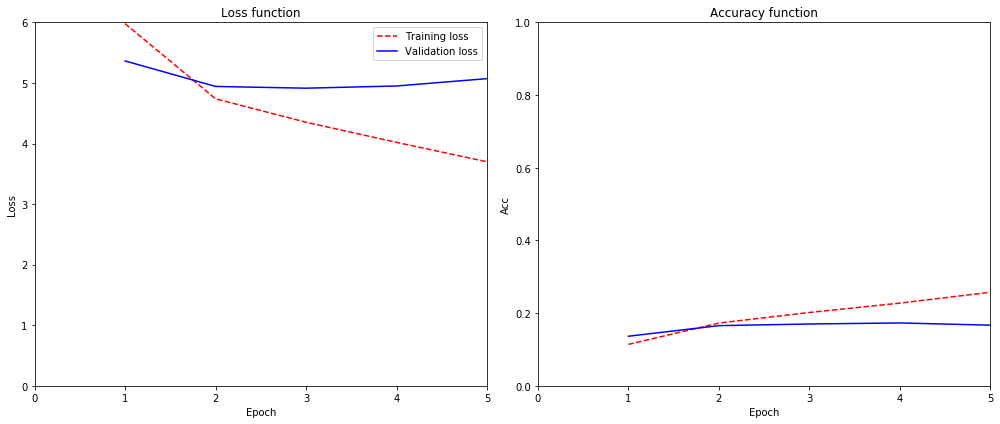

In [124]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [125]:
seed = dataset.get_random_sequence()
print("Generating with seed:",seed, "\n")
generated_text = generate_text(model.model, seed, words_amount=50)
print(generated_text)

Generating with seed: that miss montag would like to have a few words with 

a long time ago, and its very possible for a while.
 but, you dont want to be in my way, i dont know how it is.
 but i can do you, said the painter, but i dont want to go in the way
